In [ ]:
# !pip install gym torch numpy matplotlib
# !pip install pyvirtualdisplay # if no GUI


In [ ]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import matplotlib.pyplot as plt


In [ ]:

class Actor(nn.Module):
    def __init__(self, env, hidden_size=256):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], hidden_size)  # A fully connected (dense) layer that transforms the input from the observation space size
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.mean = nn.Linear(hidden_size, env.action_space.shape[0]) #outputs the mean of the action distribution
        self.log_std = nn.Linear(hidden_size, env.action_space.shape[0])  #outputs the logarithm of the standard deviation of the action distribution,
        self.tanh = nn.Tanh() # Hyperbolic tangent function used to squeeze the output actions to be between -1 and 1
        self.softplus = nn.Softplus() #ensuring that the standard deviation is positive

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        mean = self.mean(x)
        log_std = self.log_std(x)
        log_std = torch.clamp(log_std, min=-20, max=2)
        return mean, log_std

    def sample_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        mean, log_std = self.forward(state)
        std = log_std.exp()
        normal = Normal(mean, std)
        z = normal.rsample() # Samples from this distribution using the rsample method, which allows for gradient propagation through the sampling process
        action = self.tanh(z)
        action = action.cpu().detach().numpy()
        return action[0]


In [ ]:
class Critic(nn.Module):
    def __init__(self, env, hidden_size=256):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
env = gym.make('Pendulum-v1')
 # This environment simulates the task of controlling a pendulum. The goal is to apply torque to swing the pendulum up so it stops and stays upright.
actor = Actor(env)
critic = Critic(env)
actor_optimizer = optim.Adam(actor.parameters(), lr=0.0003)
critic_optimizer = optim.Adam(critic.parameters(), lr=0.0003)


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
# Training Loop
total_rewards = []
average_rewards = []
num_episodes = 500
update_freq = 100

for episode in range(num_episodes):
    state = env.reset()
    done = False
    episode_reward = 0

    while not done:
        action = actor.sample_action(state)
        next_state, reward, done, _ = env.step(action)
        # Compute loss and update networks here
        state = next_state
        episode_reward += reward

    total_rewards.append(episode_reward)

    if (episode + 1) % update_freq == 0:
        average_reward = np.mean(total_rewards[-update_freq:])
        average_rewards.append(average_reward)
        print(f"Episode {episode + 1}, Average Reward: {average_reward}")


Episode 100, Average Reward: -1214.1029159807033
Episode 200, Average Reward: -1217.6939905490522
Episode 300, Average Reward: -1179.333997671508
Episode 400, Average Reward: -1220.019774997172
Episode 500, Average Reward: -1226.5446969212649


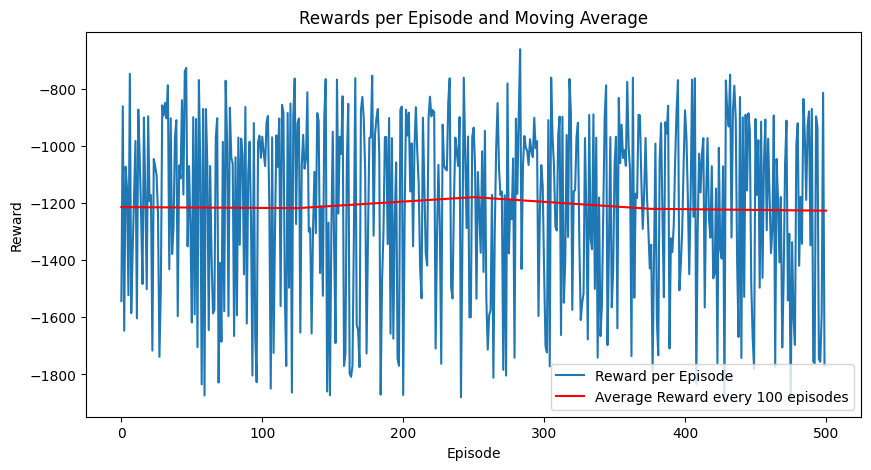

In [ ]:
def plot_rewards(rewards, averages):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards, label='Reward per Episode')
    plt.plot(np.linspace(0, len(rewards), len(averages)), averages, label='Average Reward every 100 episodes', color='r')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Rewards per Episode and Moving Average')
    plt.legend()
    plt.show()

plot_rewards(total_rewards, average_rewards)

In [ ]:
test_img = env.render(mode='rgb_array')
height, width, channels = test_img.shape

In [ ]:
import cv2

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter('simulation.mp4', fourcc, 30, (width, height))

for episode in range(5):
    state = env.reset()
    done = False
    while not done:
        img = env.render(mode='rgb_array')
        video.write(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        action = actor.sample_action(state)
        state, _, done, _ = env.step(action)
    env.close()

video.release()